In [1]:
install.packages("foreign") # foreign 패키지 설치, Spss툴
library(foreign) # SPSS 파일 로드
library(dplyr) # 전처리
library(ggplot2) # 시각화
library(readxl) # 엑셀 파일 불러오기

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
# 데이터 불러오기
raw_welfare <- read.spss(file = "/content/Koweps_hpc10_2015_beta1.sav",
                         to.data.frame = T)

# 복사본 만들기
welfare <- raw_welfare

head(welfare)
#tail(welfare)
#View(welfare)
dim(welfare)
str(welfare)
summary(welfare)

In [5]:
welfare <- rename(welfare,
                  sex = h10_g3, # 성별
                  birth = h10_g4, # 태어난 연도
                  marriage = h10_g10, # 혼인 상태
                  religion = h10_g11, # 종교
                  income = p1002_8aq1, # 월급
                  code_job = h10_eco9, # 직종 코드
                  code_region = h10_reg7) # 지역 코드
head(welfare)

,h10_id,h10_ind,h10_sn,h10_merkey,h_new,h10_cobf,h10_reg5,code_region,h10_din,h10_cin,⋯,c1007_4aq19,c1007_4aq20,c1007_4aq21,c1007_4aq22,c1007_4aq23,h10_pers_income1,h10_pers_income2,h10_pers_income3,h10_pers_income4,h10_pers_income5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,10101,0,NA,1,1,864,864,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,NA
2,2,1,1,20101,0,NA,1,1,600,600,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,NA
3,3,1,1,30101,0,NA,1,1,1571,1619,⋯,NA,NA,NA,NA,NA,NA,1440,NA,0,NA
4,4,1,1,40101,0,NA,1,1,3579,3687,⋯,NA,NA,NA,NA,NA,NA,2400,NA,0,NA
5,4,1,1,40101,0,NA,1,1,3579,3687,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,NA
6,6,1,1,60101,0,NA,1,1,3030,3486,⋯,NA,NA,NA,NA,NA,NA,NA,3000,0,NA


[1] "numeric"


   1    2 
7578 9086 


FALSE 
16664 


female   male 
  9086   7578 

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


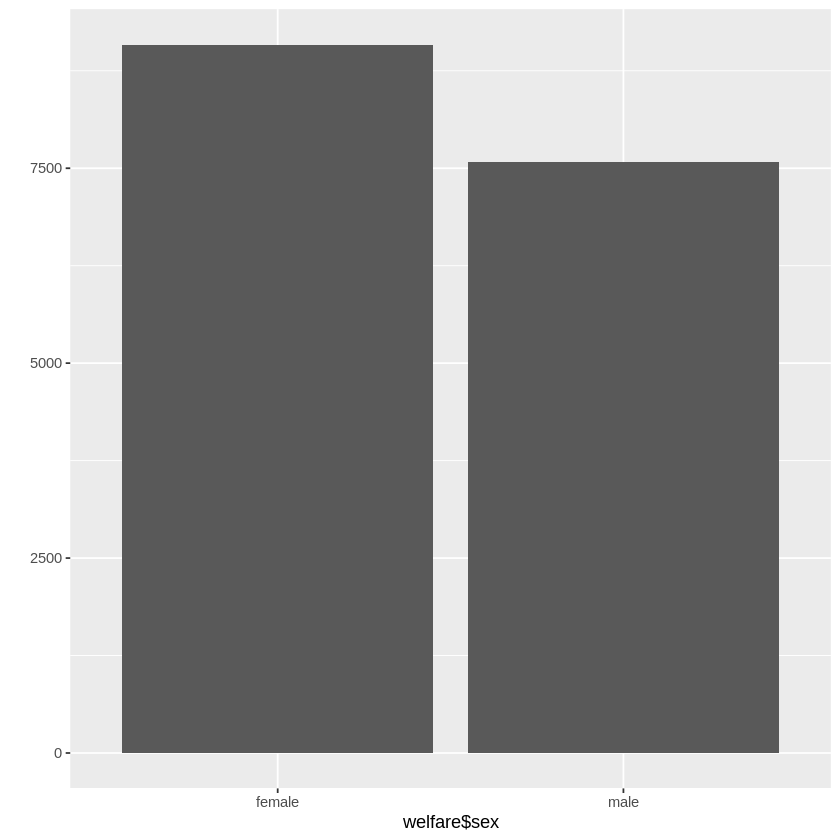

In [6]:
# .. 전처리
class(welfare$sex)
table(welfare$sex)

# 결측 및 이상치 처리
# 성별
welfare$sex <- ifelse(welfare$sex == 9, NA, welfare$sex)
table(is.na(welfare$sex))

# 성별에 항목 이름부여
welfare$sex <- ifelse(welfare$sex == 1, "male", "female")
table(welfare$sex)

qplot(welfare$sex)

In [ ]:
# 월급정보
class(welfare$income)
summary(welfare$income)
qplot(welfare$income,bins = 30) + xlim(0,1000) + ylim(0,2000) # 확대
?qplot

# 월급 이상치 결측 처리
welfare$income <- ifelse(welfare$income %in% c(0,9999), NA, welfare$income)

# 결측치 확인
table(is.na(welfare$income))


# 성별 월급 평균표 만들기
sex_income <- welfare %>%
    filter(!is.na(income)) %>%
    group_by(sex) %>%
    summarise(mean_income = mean(income))
sex_income
ggplot(data=sex_income, aes(x=sex, y=mean_income)) + geom_col()

# .. 나이값 정제
class(welfare$birth)
summary(welfare$birth)
qplot(welfare$birth)

# .. 결측 및 이상치 처리
welfare$birth <- ifelse(welfare$birth == 9999, NA, welfare$birth)
table(is.na(welfare$birth))


In [ ]:
# 나이추출: 생년 - 조사년도 + 1
welfare$age <- 2015 - welfare$birth + 1
summary(welfare$age)
qplot(welfare$age, binwidth=30)

# 1. 나이에 따른 월급 평균표 만들기
age_income <- welfare %>%filter(!is.na(income)) %>%
                group_by(age) %>% 
                summarise(mean_income=mean(income,rm.na=T))
age_income
ggplot(data=age_income, aes(x=age, y=mean_income)) + geom_col()


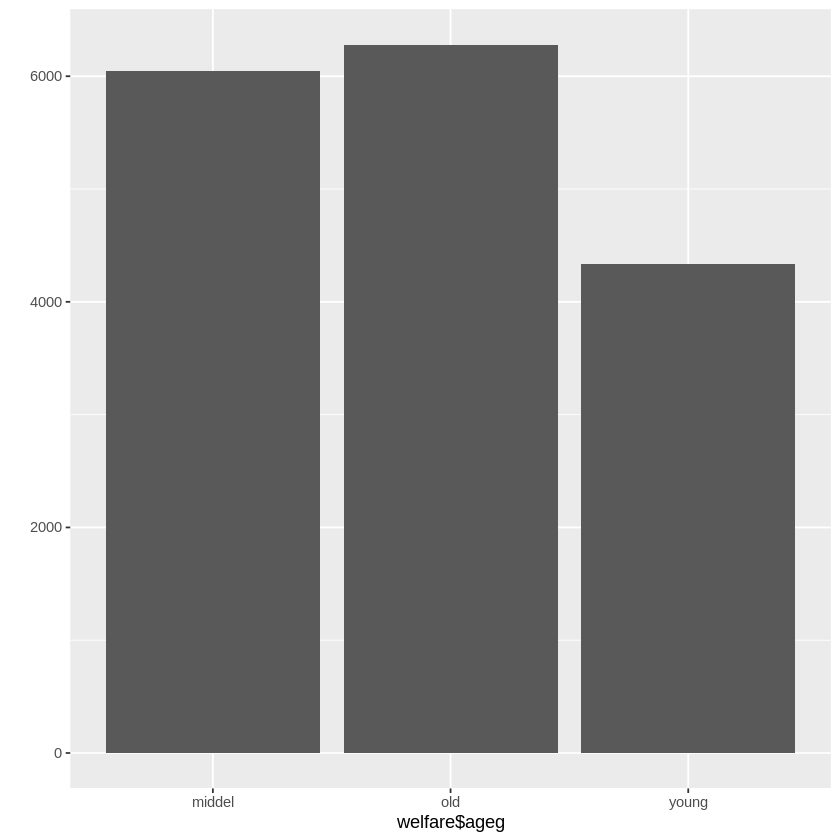

In [9]:
# 연령대 분류 30, 60
welfare <- welfare %>% 
    mutate(ageg = ifelse( welfare$age < 30, 'young',
                          ifelse( welfare$age <=59, 'middel', 'old')))
qplot(welfare$ageg)

ageg,mean_income
<chr>,<dbl>
middel,281.8871
old,125.3295
young,163.5953


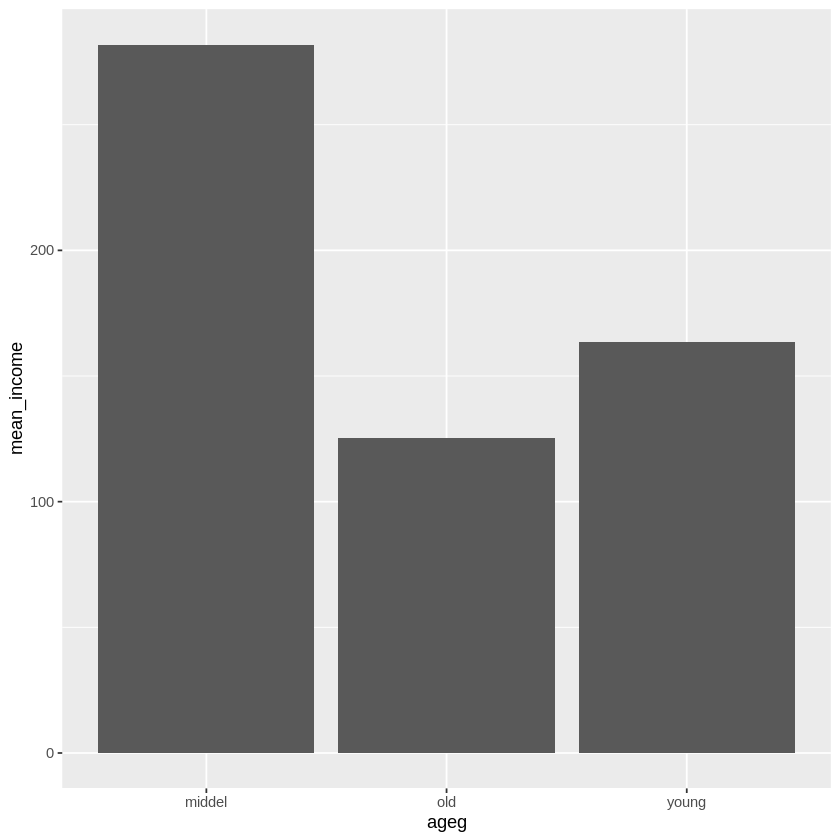

In [10]:
# 연령대에 따른 월급 차이분석
ageg_income <- welfare %>%
    filter(!is.na(income)) %>%
    group_by(ageg) %>% 
    summarise(mean_income=mean(income,rm.na=T))
ageg_income
ggplot(data=ageg_income, aes(x=ageg, y=mean_income)) + geom_col()

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


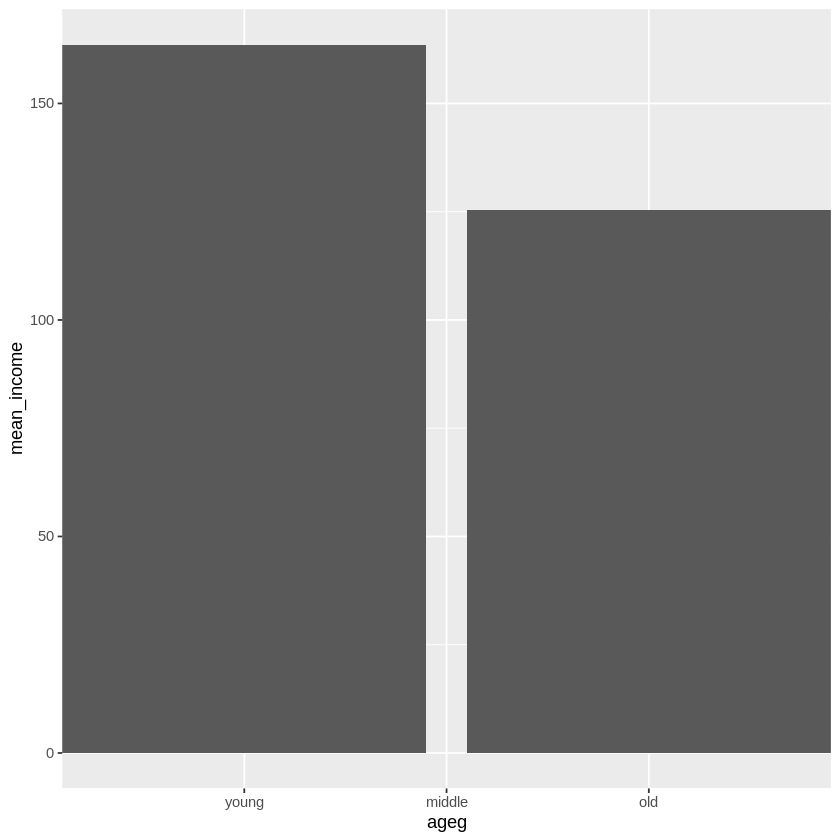

In [14]:
ggplot(data = ageg_income, aes(x = ageg, y = mean_income)) +
 geom_col() +
 scale_x_discrete(limits = c("young", "middle", "old"))

`summarise()` has grouped output by 'ageg'. You can override using the
`.groups` argument.


ageg,sex,mean_income
<chr>,<chr>,<dbl>
middel,female,187.97552
middel,male,353.07574
old,female,81.52917
old,male,173.85558
young,female,159.50518
young,male,170.81737


Warning message:
“Removed 2 rows containing missing values (`geom_col()`).”


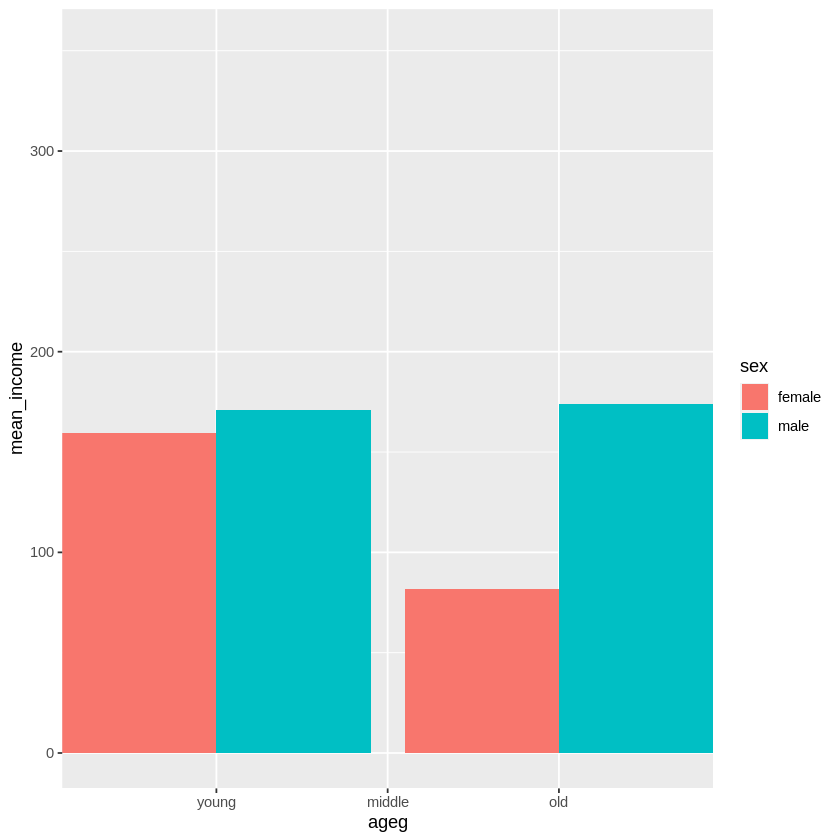

In [16]:
# 연령대 및 성별에 따른 월급 차이분석
ageg_sex_income <- welfare %>%
    filter(!is.na(income)) %>%
    group_by(ageg,sex) %>% 
    summarise(mean_income=mean(income,rm.na=T))
ageg_sex_income
ggplot(data=ageg_sex_income, aes(x=ageg, y=mean_income, fill=sex)) + 
    geom_col(position='dodge') +
    scale_x_discrete(limits = c("young", "middle", "old"))

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


age,sex,mean_income
<dbl>,<chr>,<dbl>
20,female,147.4500
20,male,69.0000
21,female,106.9789
21,male,102.0500
22,female,139.8547
22,male,118.2379
23,female,139.2821
23,male,153.2750
24,female,126.2638


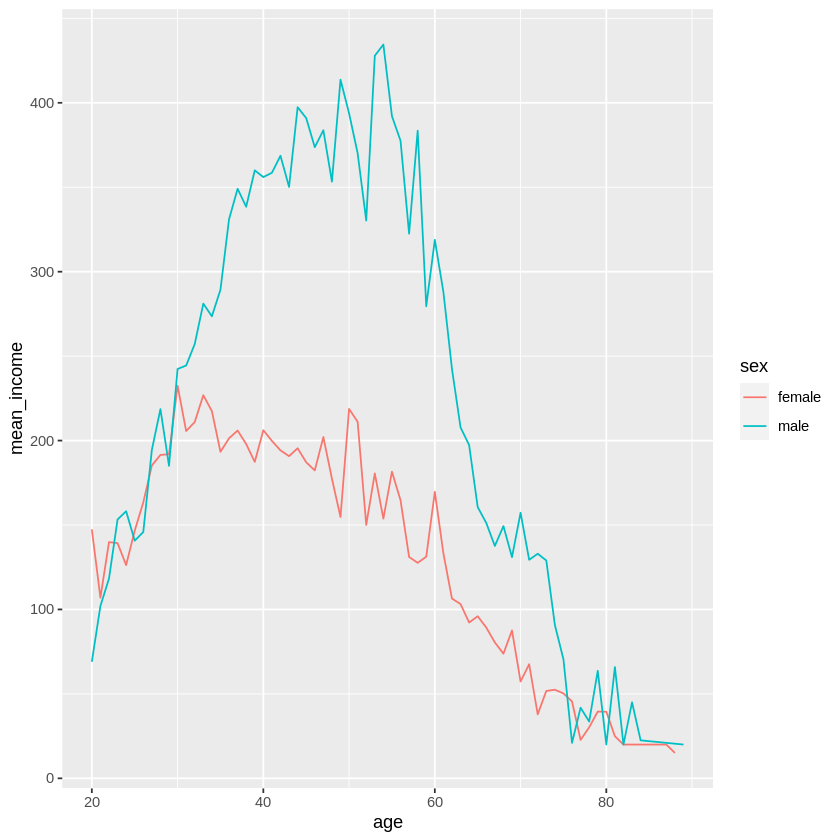

In [17]:
# 성별 연령별 월급 평균표 만들기
age_sex_income <- welfare %>%
    filter(!is.na(income)) %>%
    group_by(age, sex) %>% 
    summarise(mean_income=mean(income,rm.na=T))
age_sex_income
ggplot(data=age_sex_income, aes(x=age, y=mean_income, col=sex)) + geom_line()

In [ ]:
# 직업별 월급차이
list_job <- read_excel('./Koweps_Codebook.xlsx', col_names = T, sheet = 2)
list_job

# 코드번호 합치기
welfare <- left_join(welfare, list_job, by="code_job")

welfare %>%
    filter(!is.na(code_job)) %>%
    select(code_job, job) %>%
    head(10)

job_income <- welfare %>%
    filter(!is.na(income) & !is.na(job)) %>%
    group_by(job) %>% 
    summarise(mean_income=mean(income,rm.na=T))

head(job_income)

top10_job_income <- job_income %>% 
    arrange(desc(mean_income)) %>% 
    head(10)
top10_job_income

ggplot(data=top10_job_income, aes(x=reorder(job, mean_income), y=mean_income)) + 
    geom_col() + coord_flip()

bottom10_job_income <- job_income %>% 
    arrange(mean_income) %>% 
    head(10)
bottom10_job_income

ggplot(data=bottom10_job_income, aes(x=reorder(job, -mean_income), y=mean_income)) + 
    geom_col() + coord_flip() + ylim(0,850)


# 성별 직업빈도 상위 10개
# male
top10_male_job <- welfare %>% 
    filter(!is.na(job) & sex=='male') %>% 
    group_by(job) %>% 
    summarise(count=n()) %>% 
    arrange(desc(count)) %>% 
    head(10)
top10_male_job
ggplot(data=top10_male_job, aes(x=reorder(job, count), y=count)) + geom_col() +
    coord_flip()

# female
top10_female_job <- welfare %>% 
    filter(!is.na(job) & sex=='female') %>% 
    group_by(job) %>% 
    summarise(count=n()) %>% 
    arrange(desc(count)) %>% 
    head(10)
top10_female_job
ggplot(data=top10_female_job, aes(x=reorder(job, count), y=count)) + geom_col() +
    coord_flip()

[1] "numeric"


   1    2 
8047 8617 


  no  yes 
8617 8047 

[1] "numeric"


   0    1    2    3    4    5    6 
2861 8431 2117  712   84 2433   26 


 divorce marriage 
     712     8431 


FALSE  TRUE 
 9143  7521 

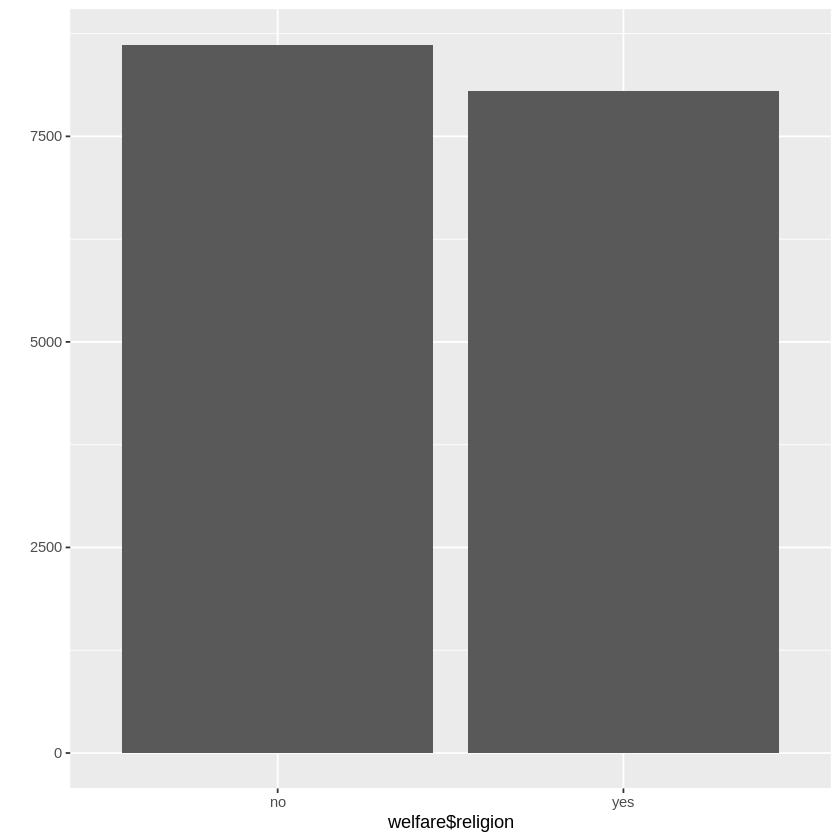

In [21]:
# 종교에 따른 이혼율
class(welfare$religion)
table(welfare$religion)

# 종교 유무 이름 부여
welfare$religion <- ifelse(welfare$religion == 1, "yes", "no")
table(welfare$religion)

qplot(welfare$religion)

# 혼인상태, 이혼변수 만들기
class(welfare$marriage)
table(welfare$marriage)

welfare$group_marriage <- ifelse(welfare$marriage == 1, "marriage",
                                 ifelse(welfare$marriage == 3, "divorce", NA))

table(welfare$group_marriage)
table(is.na(welfare$group_marriage))